In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random


#
# Définition des paramètres

In [ ]:
N = 10 # Nombre de voitures
h = 0.1  # pas de temps
mu = 30
alpha = np.random.random(N-1)


# I-   Generation & Affichage des points

Nous générons des points aléatoires avec la distribution d'une loi normale de parametre mu et sigma
ces points représentent les conditions initiales


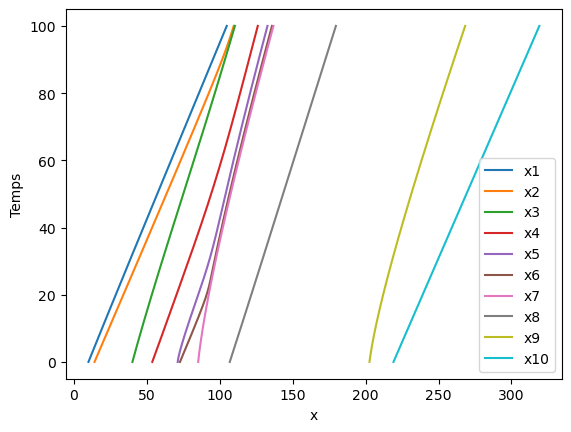

Position initiale x0
[ 10.          14.1683204   40.14914179  53.75427967  71.18722241
  72.74336494  85.21454134 106.87593204 202.65226324 219.10625153]
Position finale 
[104.8092258  109.59612398 110.38593995 126.07935747 132.7237655
 135.81441485 136.8260982  179.62790617 268.25199478 319.10625153]


In [ ]:

def initial(n,sigma= 70):
    x0 = np.random.randn(n)*sigma + mu
    x0.sort()
    x0 = np.array(x0) + np.array(np.abs(min(x0)) + 10)
    return x0
x0 = initial(N)


def Witer(n):
    W=np.zeros((n,n))
    rho = np.random.rand(n) #génération densitées de voitures
    rho[-1] = 1 #pour forcer la voiture de devant d'avancer un peu
    for i in range(0,n-1):
        coef = 1/((x0[i+1]-x0[i])*rho[i])
        W[i][i]=-coef
        W[i][i+1]=coef

    return W
W1 = Witer(N)

def sigma(u):
    if 1>=u :
        sortie=0
    else :
        sortie=1-(1/u)
    return sortie

def dxdt1(W,t, x):
    n = len(W)
    b = np.zeros(n)
    b[n-1] = 1
    dxdt = [sigma((W@x)[i])+b[i] for i  in range(n)]
    dxdt = np.array(dxdt)
    return dxdt

def solveur_fait_maison(W,dxdt, I, pas, ci):

    #on construit d'abord notre subdivision
    subdivision = np.arange(I[0], I[1], pas)
    if subdivision[-1]!=I[1]:
        subdivision = np.append(subdivision, np.float64(I[1]))

    #on lance la résolution numérique
    sol = np.array([ci])
    for i in range(len(subdivision)-1):
        soli = sol[-1]+(subdivision[i+1]-subdivision[i])*dxdt1(W,subdivision[i], sol[-1])
        sol = np.r_[sol, [soli]]

    return sol, subdivision

y,sub = solveur_fait_maison(W1,dxdt1, np.array([0, 100]), 0.1, x0)
plt.figure()
for i in range(N):
    plt.plot(y[:, i],sub, label='x'+str(i+1))

plt.legend()
plt.xlabel('x')
plt.ylabel('Temps')
plt.show()

print("Position initiale x0")
print(x0)
print("Position finale ")
print(y[-1])

# II-  APPRENTISSAGE

### a) Explication d'un détail

In [ ]:
def poids(n):
    w = np.zeros((n,n))
    for i in range(n-1):
            w[i,i] = -abs(np.random.random())
            w[i,i+1] = -w[i,i]
    return w

Avant de commencer à chercher la matrice $W$ pour résoudre l'équation différentielle, il est important de noter un détail concernant cette matrice. En effet, l'objectif est de retrouver la matrice $W$ qui nous permettra de trouver une approximation de $X(T)$ telle que $X(T) \approx Y$. Cependant, nous avons remarqué qu'une seule bonne prédiction du vecteur $W[i]$ de la matrice $W$ ne suffit pas pour retrouver $X(T)[i]$ tel que $X(T)[i] = Y[i]$. Ceci est lié au fait que les véhicules suivent leurs leaders.

Pour illustrer ce point, prenons l'exemple de $N$ véhicules dont les positions initiales et finales sont respectivement $X_0$ et $Y$. Nous avons utilisé la matrice $W_1$ pour trouver $Y$.

Si l'on remplace $w[N-3,N-3]$ par $W_1[N-3,N-3]$, cela signifie que tous les autres poids restent inchangés. Cependant, étant donné que les véhicules suivent leur leader, il est probable que cela ait un impact sur les positions de tous les autres véhicules et donc sur la position finale de la voiture 3. Par conséquent, connaître uniquement $w[N-3,N-3]$ ]$ ne suffit pas pour prédire la position finale de la voiture $N-3$.

In [ ]:
w = poids(N) # une matrice aléatoire
print(w)
#w[0,0] = W1[0,0]
w[2,2] = W1[2,2]
w[2,3] = W1[2,3]
u,sub = solveur_fait_maison(w,dxdt1, np.array([0, 100]), 0.1, x0)
it, s= y.shape


print(W1)
print(w)
print(y[-1])
print(u[-1])

[[-0.86418807  0.86418807  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.19693036  0.19693036  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.52654774  0.52654774  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.56688907  0.56688907  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.58153601  0.58153601
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.84633808
   0.84633808  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.61121111  0.61121111  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.99523763  0.99523763  0.        ]
 [ 0.          0.          0.          0.       

On observe que bien que le résultat soit proche de la prédiction initiale, il ne s'agit pas de l'égalité attendue. Cette erreur est due au fait qu'une mauvaise prédiction sur le véhicule devant peut impacter les véhicules qui le suivent. Pour résoudre ce problème, il est nécessaire de connaître les valeurs de $w[N-2,N-2]$, sachant que $w[N-1,N-1]$ est nulle. En effectuant cette modification, on obtient le résultat suivant :

In [ ]:

w[N-2,N-2] = W1[N-2,N-2]
w[N-2,N-1] = W1[N-2,N-1]
w[N-3,N-3] = W1[N-3,N-3]
w[N-3,N-2] = W1[N-3,N-2]
u,sub = solveur_fait_maison(w,dxdt1, np.array([0, 100]), 0.1, x0)
it, s= y.shape


print(W1)
print(w)
print(y[-1])
print(u[-1])

[[-3.32037877  3.32037877  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -4.25046959  4.25046959  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.19417701  0.19417701  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.37874145  0.37874145  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.82462741  0.82462741
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -2.57301944
   2.57301944  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.0612281   0.0612281   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.0411898   0.0411898   0.        ]
 [ 0.          0.          0.          0.       

### b) Apprentissage avec gradient numérique  

In [ ]:
def gradient_norme(w,x0,y,h):

    gradient = np.zeros((N,N))
    perturb = np.zeros((N,N))
    for i in range(N-1):
        #perturb = np.zeros((N,N))
        perturb[N-2-i,N-2-i] = h

        perturb[N-2-i,N-1-i] = h
        w_plus = w + perturb
        w_minus = w - perturb
        xT_plus,s1 = solveur_fait_maison(w_plus,dxdt1, np.array([0, 100]), h, x0)
        xT_plus = xT_plus[-1]
        xT_minus,s2 = solveur_fait_maison(w_minus,dxdt1, np.array([0, 100]), h, x0)
        xT_minus = xT_minus[-1]
        n_minus = np.linalg.norm(xT_minus - y)
        n_plus = np.linalg.norm(xT_plus - y)
        gradient[N-2-i,N-2-i] = -(n_plus  - n_minus)/(Niter)
        gradient[N-2-i,N-1-i] = -gradient[N-2-i,N-2-i]

    return gradient

La matrice des poids utilisée pour generer les points : 
  
 [[-3.32037877  3.32037877  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -4.25046959  4.25046959  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.19417701  0.19417701  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.37874145  0.37874145  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.82462741  0.82462741
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -2.57301944
   2.57301944  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.0612281   0.0612281   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.0411898   0.0411898  

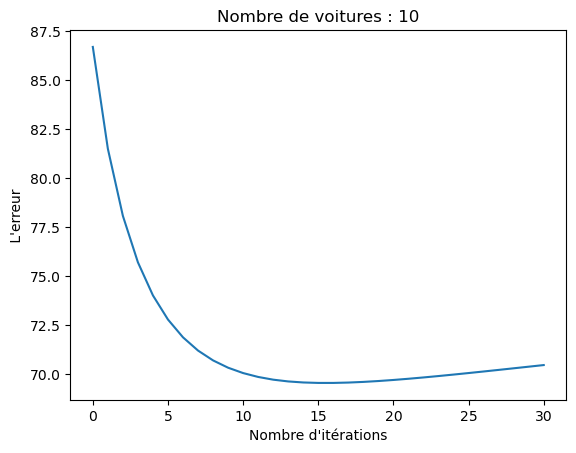

In [ ]:
Niter = 1000

w = poids(N)

h = 0.1
a = np.random.rand(N, N)  # Crée une matrice aléatoire de taille n x n


y,sub = solveur_fait_maison(W1,dxdt1, np.array([0, 100]), h, x0)
y = y[-1]

def norme(w1):
    xT,sub = solveur_fait_maison(w1,dxdt1, np.array([0, 100]), h, x0)
    xT = xT[-1]
    return(np.linalg.norm(xT - y ))

it = 0
NORM = []
m = len(x0)-1
w1 = w.copy()
print("La matrice des poids utilisée pour generer les points : \n ",'\n',W1)
print('La matrice des poids avant apprentissage : \n ','\n',w1,'\n')
x1 = np.zeros((y.shape))
while(it<=30):

    xT,sub = solveur_fait_maison(w1,dxdt1, np.array([0, 100]), 0.1, x0)
    #eps = np.sqrt(np.finfo(float).eps)  # Set the step size for finite difference
    #gradient = approx_fprime(w1.flatten(), norme, eps)
    gradient =gradient_norme(w1,x0,y,0.1)
    #norm = norme(w1)
    if it%10 == 0 :
        print("A l'itération ",it,",l'erreur = ", norme(w1) )
    NORM.append(norme(w1))
    w1 = w1 - 0.15*gradient
    it = it+1
print('\n')
print("la matrice des poids utilisée pour generer les points : \n",'\n',W1)
print('\n')
print('la matrice des poids après apprentissage : \n','\n',w1)
print('\n')
print("Prediction apres apprentissage : \n",'\n', xT[-1])
print('\n')
print('Target : \n','\n',y)
plt.figure()
plt.title('Nombre de voitures : '+str(N))
plt.xlabel("Nombre d'itérations")
plt.ylabel(" L'erreur ")
plt.plot(NORM)
plt.show()

###     c) apprentissage sans gradient numérique

In [ ]:
# y: vecteur des positions finales des véhicules que l'on souhaite obtenir
# x: vecteur des positions finales obtenues a l'itération précédente
# N:  Le nombre de véhicule
# Niter: Le nombre d'itération

def correct(y,x):
    n = len(x)
    w1 = np.zeros((n,n))
    for i in range(n-1):
        w1[i,i+1] = (x[i] -y[i])/Niter
        w1[i,i] = -(x[i] -y[i])/Niter

    return w1

In [ ]:
Niter = 1000
#w = poids(N)
h = 0.1
def grad_norm(xT,y,w):
    z = xT[-1] - y
    grad_norme = -2 * w.T @ (np.exp(1 / (w @ xT[-1])) * z.reshape(-1, 1) / np.dot(xT[-1], xT[-1]))
    return grad_norme

def norme(w1,y):
    xT,sub = solveur_fait_maison(w1,dxdt1, np.array([0, 100]), 0.1, x0)
    xT = xT[-1]
    return(np.linalg.norm(xT - y ))

y,sub = solveur_fait_maison(W1,dxdt1, np.array([0, 100]), 0.1, x0)
y = y[-1]
def apprentissage1(x0,y):
    w = poids(len(x0))

    it = 0
    NORM = []
    w1 = w.copy()
    print("La matrice des poids utilisée pour generer les points : \n ",'\n',W1)
    print('La matrice des poids avant apprentissage : \n ','\n',w1,'\n')
    while(it<=150):
        xT,sub = solveur_fait_maison(w1,dxdt1, np.array([0, 100]), 0.1, x0)
        if it%50 == 0 :
            print("A l'itération ",it,",l'erreur = ", norme(w1,y) )
        NORM.append(norme(w1,y))
        w2= correct(y,xT[-1])
        w1 = w1 - 0.6*w2
        it = it+1
    #print(gradient[0])

    print('\n')
    print("la matrice des poids utilisée pour generer les points : \n",'\n',W1)
    print('\n')
    print('la matrice des poids après apprentissage : \n','\n',w1)
    print('\n')
    print("Prediction apres apprentissage : \n",'\n', xT[-1])
    print('\n')
    print('Target : \n','\n',y)
    plt.figure()
    plt.title('Nombre de voitures : '+str(N))
    plt.xlabel("Nombre d'itérations")
    plt.ylabel(" L'erreur ")
    plt.plot(NORM)
    plt.show()

La matrice des poids utilisée pour generer les points : 
  
 [[-0.09899495  0.09899495  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.18125064  0.18125064  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         -0.04826046  0.04826046  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         -0.06533189  0.06533189  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.10755206  0.10755206
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.8644247
   0.8644247   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.05304078  0.05304078  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         -0.5815712   0.5815712   

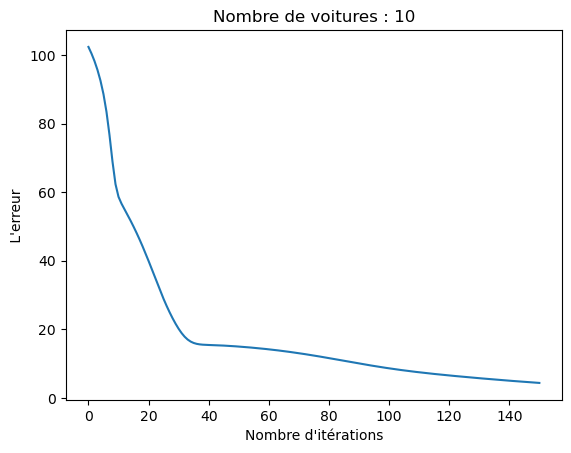

In [ ]:

N = 10
x0 = initial(N)
W1 = Witer(N)
y,sub = solveur_fait_maison(W1,dxdt1, np.array([0, 100]), 0.1, x0)
y = y[-1]
apprentissage1(x0,y)

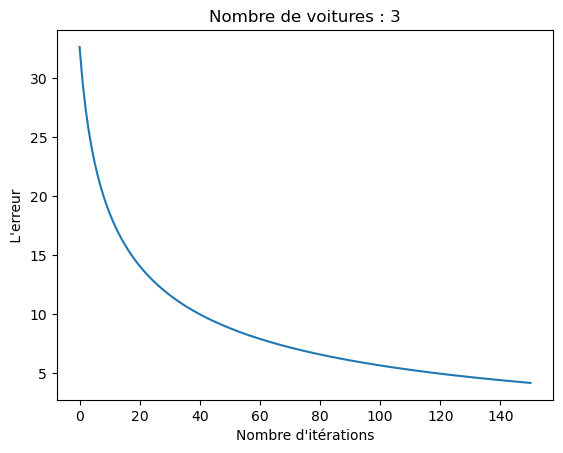

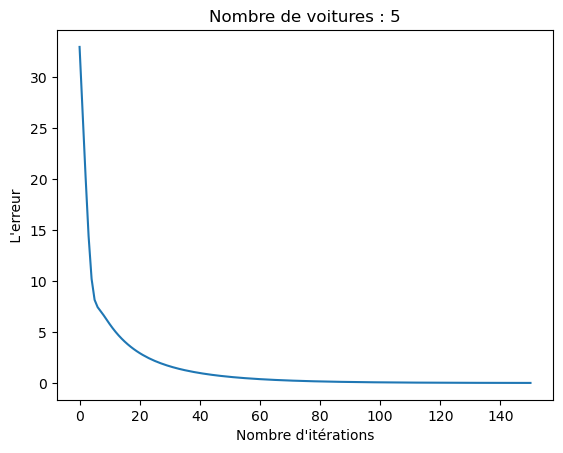

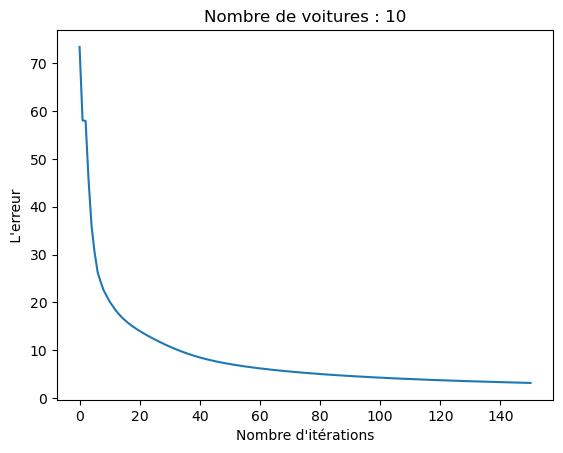

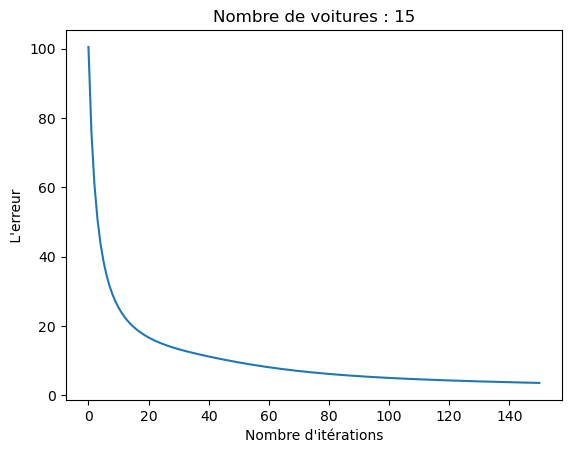

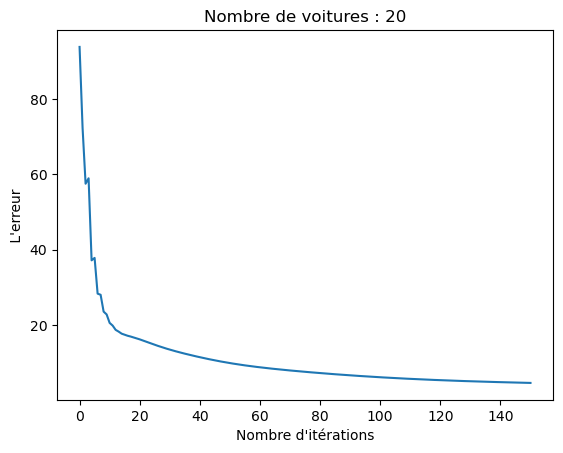

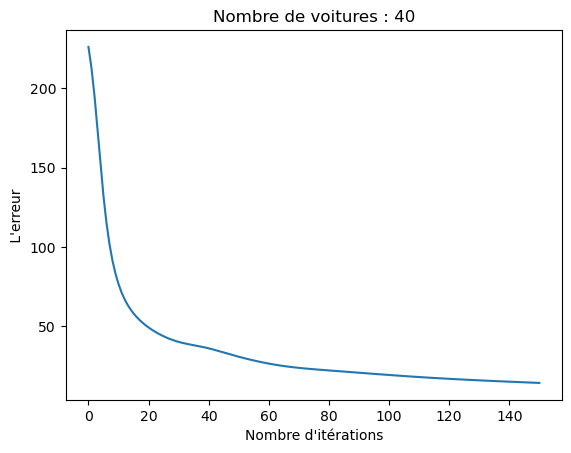

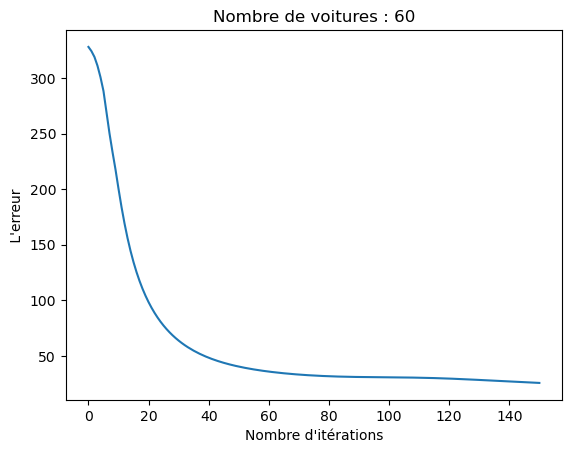

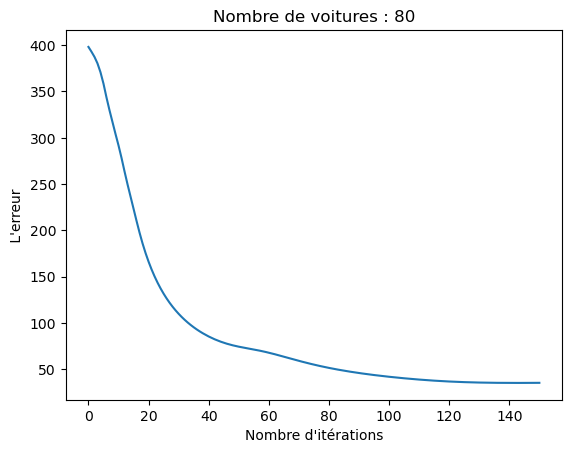

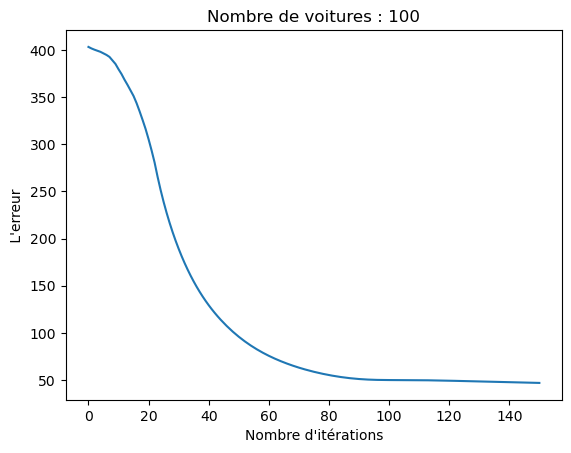

In [ ]:
def apprentissage(x0,y):
    w = poids(len(x0))
    it = 0
    NORM = []
    w1 = w.copy()
    while(it<=150):
        xT,sub = solveur_fait_maison(w1,dxdt1, np.array([0, 100]), 0.1, x0)
        w2= correct(y,xT[-1])
        w1 = w1 - 0.6*w2
        it = it+1
        NORM.append(norme(w1,y))
    plt.figure()
    plt.title('Nombre de voitures : '+str(len(x0)))
    plt.xlabel("Nombre d'itérations")
    plt.ylabel(" L'erreur ")
    plt.plot(NORM)
    plt.show()

taille = [3,5, 10,15,20, 40, 60, 80,100]

for i in taille:
    x0 = initial(i)
    W1 = Witer(i)
    y,sub = solveur_fait_maison(W1,dxdt1, np.array([0, 100]), 0.1, x0)
    y = y[-1]
    apprentissage(x0,y)